In [1]:
import networkx as nx
import numpy as np
import torch
from model import CaT
from CaT.datasets import reorder_dag, get_full_ordering
from utils.inference import CausalInference
import matplotlib.pyplot as plt

seed = 1
standardize = 0
sample_size = 50000
batch_size = 100
max_iters = 6000
eval_interval = 200
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 6
num_heads = 2
n_layers = 2
embed_dim = 5
head_size = 6
d = 5


def generate_data_mediation(N, d=5):
    DAGnx = nx.DiGraph()
    
    Ux = np.random.randn(N,d)
    X =  Ux

    Um = np.random.randn(N,d)
    M =  0.2 * X + Um

    Uy = np.random.randn(N,d)
    Y =  0.7 * M + 0.1 * Uy

    M0 = 0.2 * 0 + Um 
    M1 = 0.2 * 1 + Um

    Y0 = 0.7 * M0 + 0.1 * Uy 
    Y1 = 0.7 * M1 + 0.1 * Uy   # total effect   = 0.7 * 0.2 = 0.14

    all_data_dict = {'X': X, 'M': M, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont', 'M': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'M'), ('M', 'Y')])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)

    return all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1

In [2]:
d=3
_, _, _, _, _, Y0, Y1 = generate_data_mediation(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  # multi-dim ATE based off a large sample
all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data_mediation(N=sample_size, d=d)
print(var_names, ATE)
print(all_data.shape)

indices = np.arange(0, len(all_data))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data[train_inds]
val_data = all_data[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

['X', 'M', 'Y'] [0.14 0.14 0.14]
(50000, 3, 3)


In [3]:
input_dim = all_data.shape[2]

model = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx,
                    causal_ordering=causal_ordering,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model(X=xb, targets=xb_mod)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
    

step 0 of 6000: train_loss 4.1337, val loss 4.1061
step 200 of 6000: train_loss 1.0236, val loss 0.9932
step 400 of 6000: train_loss 1.0141, val loss 0.9928
step 600 of 6000: train_loss 1.0146, val loss 0.9888
step 800 of 6000: train_loss 1.0202, val loss 0.9930
step 1000 of 6000: train_loss 1.0089, val loss 0.9970
step 1200 of 6000: train_loss 1.0301, val loss 0.9861
step 1400 of 6000: train_loss 1.0110, val loss 0.9848
step 1600 of 6000: train_loss 1.0164, val loss 0.9980
step 1800 of 6000: train_loss 1.0131, val loss 0.9892
step 2000 of 6000: train_loss 1.0106, val loss 0.9999
step 2200 of 6000: train_loss 1.0086, val loss 1.0064
step 2400 of 6000: train_loss 1.0161, val loss 0.9968
step 2600 of 6000: train_loss 1.0180, val loss 0.9868
step 2800 of 6000: train_loss 1.0250, val loss 1.0077
step 3000 of 6000: train_loss 1.0170, val loss 0.9947
step 3200 of 6000: train_loss 1.0192, val loss 1.0000
step 3400 of 6000: train_loss 1.0028, val loss 0.9935
step 3600 of 6000: train_loss 1.010

ATE: [0.14 0.14 0.14] est ATE: [0.13401228 0.15703369 0.13112091] error: [0.00598772 0.01703369 0.00887909]


/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:18: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


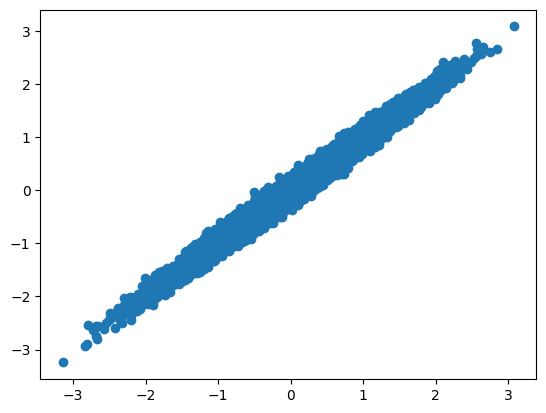

In [5]:
model.eval()
inf = CausalInference(dag=DAGnx)

int_nodes_vals0 = {'X':np.array([0.0,])}
int_nodes_vals1 = {'X':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names.index(effect_var)

preds0 = inf.forward(all_data, model=model, intervention_nodes_vals=int_nodes_vals0)
preds1 = inf.forward(all_data, model=model, intervention_nodes_vals=int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model(train_data.to(device)).detach().cpu().numpy()

plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1])

In [7]:
model.eval()
inf = CausalInference(dag=DAGnx)

int_nodes_vals0 = {'X':np.array([0.0,])}
int_nodes_vals1 = {'X':np.array([1.0,])}
effect_var = 'M'
effect_index = var_names.index(effect_var)

preds0 = inf.forward(all_data, model=model, intervention_nodes_vals=int_nodes_vals0)
preds1 = inf.forward(all_data, model=model, intervention_nodes_vals=int_nodes_vals1)
ATE = np.array([0.5, 0.5, 0.5])
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('est ATE:', ATE_pred, 'error:', eATE)

est ATE: [0.19732073 0.20942023 0.18575056] error: [0.30267927 0.29057977 0.31424944]
